


### Requirements

In [2]:
import numpy as np
import tensorflow as tf
import sys
from copy import deepcopy
import os

### MODEL ARCHITECTURE

In [3]:
import numpy as np
import tensorflow as tf
def positional_encoding(max_seq_len, dm):
    
    PE = np.zeros((max_seq_len, dm))
    for row in range(max_seq_len):
        for col in range(0, dm, 2):
            PE[row, col] = np.sin(row / (10000 ** (col / dm)))
            PE[row, col + 1] = np.cos(row / (10000 ** (col / dm)))
    return PE


def sdp_attention(Q, K, V, mask=None):
    QK = tf.matmul(Q, K, transpose_b=True)
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled = QK / tf.math.sqrt(dk)
    if mask is not None:
        mask = tf.expand_dims(tf.expand_dims(mask, 0), 1)
        scaled += mask * -1e9
    weights = tf.nn.softmax(scaled, axis=-1)
    output = tf.matmul(weights, V)

    return output, weights


class MultiHeadAttention(tf.keras.layers.Layer):
   
    def __init__(self, dm, h):
        super(MultiHeadAttention, self).__init__()
        self.h = h
        self.dm = dm
        self.depth = dm // self.h
        self.Wq = tf.keras.layers.Dense(dm)
        self.Wk = tf.keras.layers.Dense(dm)
        self.Wv = tf.keras.layers.Dense(dm)
        self.linear = tf.keras.layers.Dense(dm)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.h, self.depth))
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return x

    def call(self, Q, K, V, mask):
        batch_size = tf.shape(Q)[0]

        Q = self.Wq(Q)
        K = self.Wk(K)
        V = self.Wv(V)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        attention, weights = sdp_attention(Q, K, V, mask)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        attention = tf.reshape(attention, (batch_size, -1, self.dm))
        output = self.linear(attention)

        return output, weights


class DecoderBlock(tf.keras.layers.Layer):
   
    def __init__(self, dm, h, hidden, drop_rate=0.1, name=None):
        
        super(DecoderBlock, self).__init__()
        if name is not None:
            self._name = name
        self.mha1 = MultiHeadAttention(dm, h)
        self.mha2 = MultiHeadAttention(dm, h)
        self.dense_hidden = tf.keras.layers.Dense(
            units=hidden,
            activation='relu'
        )
        self.dense_output = tf.keras.layers.Dense(units=dm)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(drop_rate)
        self.dropout2 = tf.keras.layers.Dropout(drop_rate)

    def call(self, inputs, look_ahead_mask, training=False):
       
        attn_out, _ = self.mha1(inputs, inputs, inputs, look_ahead_mask)
        attn_out = self.dropout1(attn_out, training=training)

        out = self.layernorm1(inputs + attn_out)

        dense_output = self.dense_hidden(out)
        dense_output = self.dense_output(dense_output)
        dense_output = self.dropout2(dense_output, training=training)

        out = self.layernorm2(out + dense_output)

        return out


class Decoder(tf.keras.Model):
    
    def __init__(self,
                 Nb,                # Number of blocks in model base
                 No,                # Number of blocks in offset branch
                 Np,                # Number of blocks in pen state branch
                 dm,                # Model dimensionality
                 h,                 # Number of heads used in attention
                 hidden,            # Hidden layer dimenssionality
                 max_seq_len,
                 num_classes,       # Maximum sequence length
                 drop_rate=0.1):    # Drop rate used in dropout layers

        super(Decoder, self).__init__()
        self.Nb = Nb
        self.No = No
        self.Np = Np
        self.dm = dm
        self.num_classes = num_classes
        # Replace the class_embedding Dense layer with:
        
        self.class_embedding = tf.keras.layers.Dense(dm, name='class_embedding')
        self.layernorm_class = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.projection = tf.keras.layers.Dense(dm, name='base_projection')
        self.positional_encoding = positional_encoding(max_seq_len, dm)
        self.dropout = tf.keras.layers.Dropout(drop_rate)

        self.base_blocks = [
            DecoderBlock(dm, h, hidden, drop_rate,
            name="base_block_" + str(n)) for n in range(Nb)
        ]
        self.offset_blocks = [
            DecoderBlock(dm, h, hidden, drop_rate,
            name="offset_block_" + str(n)) for n in range(No)
        ]
        self.pen_blocks = [
            DecoderBlock(dm, h, hidden, drop_rate,
            name="pen_block_" + str(n)) for n in range(Np)
        ]

        self.offset_dense = tf.keras.layers.Dense(dm, name='offset_dense')
        self.offset_out = tf.keras.layers.Dense(2, name='offset_out')
        self.pen_dense = tf.keras.layers.Dense(dm, name='pen_dense')
        self.pen_out = tf.keras.layers.Dense(3, name='pen_out',
                                             activation='softmax')

    def call(self,inputs,labels,look_ahead_mask=None,training=False):       
        
        class_emb = self.class_embedding(labels)  
        class_emb = self.layernorm_class(class_emb)
        class_emb = tf.expand_dims(class_emb, axis=1)
        #--------------#
        # if tf.shape(inputs)[1] == 0:  
        #     x = class_emb  
        # else:
        #     x = self.projection(inputs)  
        #     x = tf.concat([class_emb, x], axis=1) 
        #--------------#     
        x = self.projection(inputs)
        x = tf.concat([class_emb, x], axis=1)
        seq_len = tf.shape(x)[1]
        x *= tf.math.sqrt(tf.cast(self.dm, 'float32'))
        x += self.positional_encoding[:seq_len]
        # pos_encoding = tf.expand_dims(self.positional_encoding[:seq_len], 0)
        # x += pos_encoding
        x = self.dropout(x, training=training)

        for block in self.base_blocks:
            x = block(x, look_ahead_mask, training=training)

        offset = x
        for block in self.offset_blocks:
            offset = block(offset, look_ahead_mask, training=training)
        offset = self.offset_dense(offset)
        offset = self.offset_out(offset)

        pen = x
        for block in self.pen_blocks:
            pen = block(pen, look_ahead_mask, training=training)
        pen = self.pen_dense(pen)
        pen = self.pen_out(pen)

        return offset, pen


### DATASET CLEANING AND LOADING

In [9]:
# def to_big_strokes(stroke, max_len=250):
#   result = np.zeros((max_len, 5), dtype=float)
#   l = len(stroke)
#   assert l <= max_len
#   result[0:l, 0:2] = stroke[:, 0:2]
#   result[0:l, 3] = stroke[:, 2]
#   result[0:l, 2] = 1 - result[0:l, 3]
#   result[l:, 4] = 1
#   return result

# def clean(data, max_length=100):
#     dataset = []
#     for sample in data:
#         if len(sample) <= max_length:
#             sample = to_big_strokes(sample, max_length)
#             dataset.append(sample)
#     dataset = np.asarray(dataset)
#     return dataset

# class Dataset:   
#     def __init__(self,filepath,batch_size=32,max_length=250):
#         self.strokes_list = []
#         self.labels_list = []
#         samples_per_class=30000 #samples
#         self.num_classes = len(filepaths)
#         for label, filepath in enumerate(filepaths):
#             data = np.load(filepath, encoding='latin1', allow_pickle=True)
#             train_data = data['train']
#             if len(train_data) > samples_per_class:
#                 indices = np.random.choice(len(train_data), samples_per_class, replace=False)
#                 train_data = train_data[indices]
#             else:
#                 print(f"Warning: {filepath} has only {len(train_data)} samples, less than {samples_per_class}")
            
#             train = clean(train_data, max_length)
#             self.strokes_list.append(train)

#             one_hot_labels = np.zeros((len(train), self.num_classes), dtype=np.float32)
#             one_hot_labels[:, label] = 1  # Set the column corresponding to the class to 1
#             self.labels_list.append(one_hot_labels)
#             # self.labels_list.append(np.full((len(train),), label, dtype=np.int32))
#         self.train_strokes = np.concatenate(self.strokes_list, axis=0) 
#         self.train_labels = np.concatenate(self.labels_list, axis=0)
#         self.train = tf.data.Dataset.from_tensor_slices((self.train_strokes, self.train_labels))
#         self.train = self.train.shuffle(buffer_size=len(self.train_strokes)).batch(batch_size)


In [10]:
import numpy as np
import tensorflow as tf

def to_big_strokes(stroke, max_len=250):
    # Initialize the result array
    result = np.zeros((max_len, 5), dtype=float)
    l = len(stroke)
    assert l <= max_len
    
    if l > 0:  # Ensure there’s at least one stroke to process
        # Extract x and y coordinates
        x = stroke[:, 0]
        y = stroke[:, 1]
        
        # Find min and max for normalization
        min_x, max_x = np.min(x), np.max(x)
        min_y, max_y = np.min(y), np.max(y)
        
        # Normalize x and y to [0, 1], handling edge cases
        if max_x > min_x:
            x_norm = (x - min_x) / (max_x - min_x)
        else:
            x_norm = np.zeros_like(x)  # Single-point case
        if max_y > min_y:
            y_norm = (y - min_y) / (max_y - min_y)
        else:
            y_norm = np.zeros_like(y)  # Single-point case
        
        # Assign normalized coordinates
        result[0:l, 0] = x_norm
        result[0:l, 1] = y_norm
        # Assign pen states
        result[0:l, 3] = stroke[:, 2]  # Pen state (0 for drawing, 1 for up)
        result[0:l, 2] = 1 - result[0:l, 3]  # 1 for drawing, 0 for up
    
    # Set padding indicator
    result[l:, 4] = 1  # 1 for padded steps
    
    return result

# Your existing clean function (unchanged)
def clean(data, max_length=100):
    dataset = []
    for sample in data:
        if len(sample) <= max_length:
            sample = to_big_strokes(sample, max_length)
            dataset.append(sample)
    dataset = np.asarray(dataset)
    return dataset

# Your existing Dataset class (unchanged)
class Dataset:   
    def __init__(self, filepaths, batch_size=32, max_length=250):
        self.strokes_list = []
        self.labels_list = []
        samples_per_class = 30000  # samples
        self.num_classes = len(filepaths)
        for label, filepath in enumerate(filepaths):
            data = np.load(filepath, encoding='latin1', allow_pickle=True)
            train_data = data['train']
            if len(train_data) > samples_per_class:
                indices = np.random.choice(len(train_data), samples_per_class, replace=False)
                train_data = train_data[indices]
            else:
                print(f"Warning: {filepath} has only {len(train_data)} samples, less than {samples_per_class}")
            
            train = clean(train_data, max_length)
            self.strokes_list.append(train)

            one_hot_labels = np.zeros((len(train), self.num_classes), dtype=np.float32)
            one_hot_labels[:, label] = 1  # Set the column corresponding to the class to 1
            self.labels_list.append(one_hot_labels)
        
        self.train_strokes = np.concatenate(self.strokes_list, axis=0) 
        self.train_labels = np.concatenate(self.labels_list, axis=0)
        self.train = tf.data.Dataset.from_tensor_slices((self.train_strokes, self.train_labels))
        self.train = self.train.shuffle(buffer_size=len(self.train_strokes)).batch(batch_size)

### TRAIN FUNCTION

In [11]:
def train_model(Nb,No,Np,dm,h,hidden,max_len,batch_size,epochs,filepath,verbose=1,weights=None):
    data = Dataset(filepath, batch_size=batch_size, max_length=max_len)
    num_classes = len(filepaths)
    model = Decoder(Nb, No, Np, dm, h, hidden, max_len,num_classes)
    inputs = np.random.uniform(size=(1, max_len - 1, 5))
    dummy_labels = np.zeros((1, num_classes), dtype=np.float32)
    dummy_labels[0, 0] = 1.0
    model(tf.convert_to_tensor(inputs, dtype=tf.float32), 
          tf.convert_to_tensor(dummy_labels, dtype=tf.int32), 
          None)
    # model(inputs, dummy_labels, None)
    model.summary()
   
    offset_weights = []
    pen_weights = []
    for weight in model.trainable_weights:
        if "base" in weight.name:
            offset_weights.append(weight)
            pen_weights.append(weight)
        if "offset" in weight.name:
            offset_weights.append(weight)
        if "pen" in weight.name:
            pen_weights.append(weight)

    offset_loss_func = tf.keras.losses.MeanSquaredError()
    pen_loss_func = tf.keras.losses.CategoricalCrossentropy()

    pen_train_loss = tf.keras.metrics.Mean(name='pen_train_loss')
    offset_train_loss = tf.keras.metrics.Mean(name='offset_train_loss')
    learning_rate = 0.0001
   
    # offset_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # pen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # mask = 1 - tf.linalg.band_part(tf.ones((max_len - 1, max_len - 1)), -1, 0)
    mask = 1 - tf.linalg.band_part(tf.ones((max_len, max_len)), -1, 0)
    offset_losses = []
    pen_losses = []
    prev_best = 10000

    def train_step(inputs,labels, real):
    
        with tf.GradientTape(persistent=True) as tape:
            offsets, pen_states = model(inputs,labels, mask, training=True)
            # Change from offsets[:, :-1, :] to offsets[:, 1:, :]
            offset_loss = offset_loss_func(real[:, :, :2], offsets[:, :-1, :])
            # Change from pen_states[:, :-1, :] to pen_states[:, 1:, :]
            pen_loss = pen_loss_func(real[:, :, 2:], pen_states[:, :-1, :])
            total_loss = offset_loss + pen_loss  # Combine losses

        # grads = tape.gradient(offset_loss, offset_weights)
        # offset_optimizer.apply_gradients(zip(grads, offset_weights))

        # grads = tape.gradient(pen_loss, pen_weights)
        # pen_optimizer.apply_gradients(zip(grads, pen_weights))
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        offset_train_loss(offset_loss)
        pen_train_loss(pen_loss)

        del tape

    for epoch in range(epochs):

        offset_train_loss.reset_state()
        pen_train_loss.reset_state()

        for batch, (strokes, labels) in enumerate(data.train):
            inputs = strokes[:, :-1, :]  
            real = strokes[:, 1:, :]     
            train_step(inputs, labels, real)
            offset_losses.append(offset_train_loss.result())
            pen_losses.append(pen_train_loss.result())

            if verbose == 2: 
                if batch % 50 == 0:
                    if batch % 50 == 0:
                        print("Epoch {}, batch {}: Offset Loss: {} Pen Loss {}"
                        .format(
                            epoch + 1,
                            batch,
                            offset_train_loss.result(),
                            pen_train_loss.result()
                        ))

        if verbose >= 1:  
            print("Epoch {}: Offset Loss: {:.4f} Pen Loss {:.4f}".format(
                epoch + 1,
                offset_train_loss.result(),
                pen_train_loss.result()
            ))

        
        if offset_train_loss.result() < prev_best:
            model.save_weights('new_model_weight_v1.h5')
            prev_best = offset_train_loss.result()

    return model, offset_losses, pen_losses



### DATASET

In [12]:
Dataset_path = r"/kaggle/input/sketchdata"
filepaths = []
for dirname, _, filenames in os.walk(Dataset_path):
  for filename in filenames:
    filepaths.append(os.path.join(dirname, filename))

In [13]:
filepaths

['/kaggle/input/sketchdata/sketchrnn_moon.full.npz',
 '/kaggle/input/sketchdata/sketchrnn_banana.npz',
 '/kaggle/input/sketchdata/sketchrnn_eraser.full.npz',
 '/kaggle/input/sketchdata/sketchrnn_ladder.full.npz',
 '/kaggle/input/sketchdata/sketchrnn_door.full.npz']

In [15]:
data = Dataset(filepaths, batch_size=64, max_length=100)

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

small_model, offset_losses, pen_losses = train_model(
    8,              # Base blocks
    4,              # Offset blocks
    4,              # Pen state blocks
    256,            # Model dimensionality
    8,              # Heads
    1024,            # Hidden units
    100,            # Max sequence length
    64,             # Batch size
    5,              # Epochs
    filepaths,      # File path
    2,              # Verbosity
    )# Weights to load if continuing training


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder_block_32', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder_block_33', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder_block_34', however the 

Model: "decoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ class_embedding (Dense)              │ (1, 256)                    │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_66               │ (1, 256)                    │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ base_projection (Dense)              │ (1, 99, 256)                │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (1, 100, 256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_32 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_33 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_34 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_35 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_36 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_37 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_38 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_39 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_40 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_41 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_42 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_43 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_44 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_45 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_46 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_47 (DecoderBlock)      │ ?                           │         789,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ offset_dense (Dense)                 │ (1, 100, 256)               │          65,7

 Total params: 12,772,613 (48.72 MB)

 Trainable params: 12,772,613 (48.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1, batch 0: Offset Loss: 1.929089903831482 Pen Loss 0.9596592783927917
Epoch 1, batch 50: Offset Loss: 0.5684215426445007 Pen Loss 0.6788382530212402
Epoch 1, batch 100: Offset Loss: 0.3455033302307129 Pen Loss 0.5288590788841248
Epoch 1, batch 150: Offset Loss: 0.2591436803340912 Pen Loss 0.4247969090938568
Epoch 1, batch 200: Offset Loss: 0.2097185105085373 Pen Loss 0.3595448136329651
Epoch 1, batch 250: Offset Loss: 0.17787130177021027 Pen Loss 0.31955865025520325
Epoch 1, batch 300: Offset Loss: 0.15541891753673553 Pen Loss 0.2923281490802765
Epoch 1, batch 350: Offset Loss: 0.13865190744400024 Pen Loss 0.2722129225730896
Epoch 1, batch 400: Offset Loss: 0.12566378712654114 Pen Loss 0.25726014375686646
Epoch 1, batch 450: Offset Loss: 0.11524899303913116 Pen Loss 0.2457573413848877
Epoch 1, batch 500: Offset Loss: 0.10672842711210251 Pen Loss 0.23612147569656372
Epoch 1, batch 550: Offset Loss: 0.0996202602982521 Pen Loss 0.22865808010101318
Epoch 1, batch 600: Offset Loss: 0

ValueError: The filename must end in `.weights.h5`. Received: filepath=new_model_weight_v1.h5

In [18]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 2


In [10]:
small_model.load_weights('epoch_best.h5')

In [53]:
def predict(model, input_strokes, label):
    inputs = input_strokes[np.newaxis, :]  # Shape: [1, seq_len, 5]
    label = label[np.newaxis, :]  # Shape: [1, num_classes]
    
    # Generate until max length or pen state is "end"
    while inputs.shape[1] < 100 and inputs[0, -1, -1] != 1:
        # Create mask for current sequence length (including class token)
        seq_len = inputs.shape[1]
        mask = create_mask(1, seq_len)
        
        # Forward pass with label
        offsets, pen_states = model(inputs, label, mask)
        offsets = np.round(offsets)
        pen_states = np.round(pen_states)
        # Get the last predicted stroke (offset + pen state)
        pred = np.concatenate((offsets[0, -1], pen_states[0, -1]))
        inputs = np.concatenate((inputs, pred.reshape(1, 1, 5)), axis=1)
    
    return inputs[0]

In [54]:
def create_mask(batch_size, seq_len):
    """
    Creates look-ahead mask for sequences including the class token.
    """
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    # mask = mask[tf.newaxis, tf.newaxis, :, :]  # Shape: [1, 1, seq_len, seq_len]
    return mask

In [11]:
filepaths

['DATASET/sketchrnn_pillow.npz',
 'DATASET/sketchrnn_diamond.npz',
 'DATASET/sketchrnn_bench.npz',
 'DATASET/sketchrnn_knife.npz',
 'DATASET/sketchrnn_screwdriver.npz',
 'DATASET/sketchrnn_finger.npz',
 'DATASET/sketchrnn_lightning.npz',
 'DATASET/sketchrnn_circle.npz',
 'DATASET/sketchrnn_candle.npz',
 'DATASET/sketchrnn_suitcase.npz']

In [12]:
import tensorflow as tf
import numpy as np

def generate_sketch(model, label, max_len, max_steps=250):
    num_classes = model.num_classes
    label_one_hot = np.zeros((1, num_classes), dtype=np.int32)
    label_one_hot[0, label] = 1.0
    label_tensor = tf.constant(label_one_hot, dtype=tf.float32) 
    strokes = []  

    for _ in range(max_steps):
        
        if len(strokes) == 0:
            
            stroke_input = tf.zeros((1, 0, 5), dtype=tf.float32)  
        else:
            
            stroke_input = tf.convert_to_tensor(strokes, dtype=tf.float32)  
            stroke_input = stroke_input[tf.newaxis, :, :]  

        seq_len = len(strokes) + 1  
        if seq_len > max_len:
            stroke_input = stroke_input[:, -max_len + 1:, :]  
            seq_len = max_len
        mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  
        offsets, pen_states = model(stroke_input, label_tensor, mask, training=False)
        next_offset = offsets[:, -1, :]  
        next_pen = pen_states[:, -1, :]  
        pen_idx = tf.argmax(next_pen, axis=-1)  
        pen_one_hot = tf.one_hot(pen_idx, depth=3)  
        next_stroke = tf.concat([next_offset, pen_one_hot], axis=-1)  
        strokes.append(next_stroke[0].numpy()) 
        if tf.reduce_all(tf.equal(pen_one_hot, [0, 0, 1])):
            break

    return np.array(strokes)

In [33]:
cat_sketch = generate_sketch(
    model=small_model,
    label=9,  # "cat"
    max_len=100,  # Must match training max_len
    max_steps=250
)

In [33]:
print("Generated sketch shape:", cat_sketch.shape)
print("First few strokes:", cat_sketch[:5])

Generated sketch shape: (16, 5)
First few strokes: [[10.924255  34.85005    1.         0.         0.       ]
 [13.800518  36.290554   1.         0.         0.       ]
 [22.190905  22.47266    1.         0.         0.       ]
 [44.70678   12.354386   1.         0.         0.       ]
 [62.62969   -6.0382643  1.         0.         0.       ]]


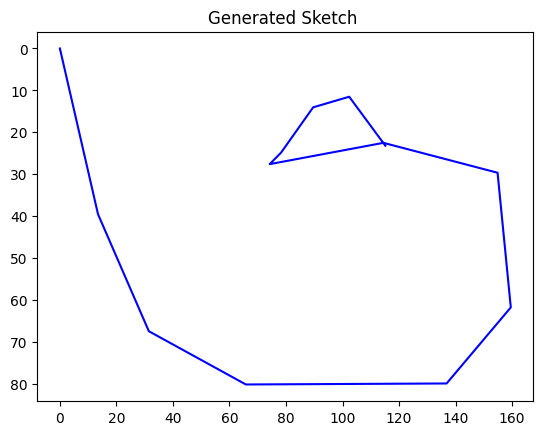

In [34]:
import matplotlib.pyplot as plt

def render_sketch(strokes):
    x, y = 0, 0
    x_coords = [x]
    y_coords = [y]
    for stroke in strokes:
        dx, dy, p1, p2, p3 = stroke
        if p1 == 1:  # Pen down
            x += dx
            y += dy
            x_coords.append(x)
            y_coords.append(y)
        elif p2 == 1:  # Pen up
            x += dx
            y += dy
            x_coords.append(None)  # Break line
            y_coords.append(None)
            x_coords.append(x)
            y_coords.append(y)
        elif p3 == 1:  # End
            break
    plt.plot(x_coords, y_coords, 'b-')
    plt.gca().invert_yaxis()
    plt.title(f"Generated Sketch ")
    plt.show()

render_sketch(cat_sketch)